# Predicting Hotel Cancellations

## 🏨 Background

You are supporting a hotel with a project aimed to increase revenue from their room bookings. They believe that they can use data science to help them reduce the number of cancellations. This is where you come in! 

They have asked you to use any appropriate methodology to identify what contributes to whether a booking will be fulfilled or cancelled. They intend to use the results of your work to reduce the chance someone cancels their booking.

## The Data

They have provided you with their bookings data in a file called `hotel_bookings.csv`, which contains the following:

| Column     | Description              |
|------------|--------------------------|
| `Booking_ID` | Unique identifier of the booking. |
| `no_of_adults` | The number of adults. |
| `no_of_children` | The number of children. |
| `no_of_weekend_nights` | Number of weekend nights (Saturday or Sunday). |
| `no_of_week_nights` | Number of week nights (Monday to Friday). |
| `type_of_meal_plan` | Type of meal plan included in the booking. |
| `required_car_parking_space` | Whether a car parking space is required. |
| `room_type_reserved` | The type of room reserved. |
| `lead_time` | Number of days before the arrival date the booking was made. |
| `arrival_year` | Year of arrival. |
| `arrival_month` | Month of arrival. |
| `arrival_date` | Date of the month for arrival. |
| `market_segment_type` | How the booking was made. |
| `repeated_guest` | Whether the guest has previously stayed at the hotel. |
| `no_of_previous_cancellations` | Number of previous cancellations. |
| `no_of_previous_bookings_not_canceled` | Number of previous bookings that were canceled. |
| `avg_price_per_room` | Average price per day of the booking. |
| `no_of_special_requests` | Count of special requests made as part of the booking. |
| `booking_status` | Whether the booking was cancelled or not. |

Source (data has been modified): https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# set up global styles for plots
plt.style.use('fivethirtyeight')
sns.set_context("notebook", font_scale=1)

# load the data
hotels = pd.read_csv("../data/hotel_bookings.csv")
hotels

## Data Cleaning

Before we being to analyse the data let's first:

* Explore
* Clean 
* Verify

In [ ]:
# rename 'Booking_ID' column to 'booking_id' for consistency
hotels.rename(columns={'Booking_ID': 'booking_id'}, inplace=True)
# confirm
display(hotels.columns)

In [ ]:
# let's see what the shape of the data is
hotels.shape

In [ ]:
# check for missing values
hotels.isnull().sum()

In [ ]:
# first let's remove any rows where least 17 values are missing
hotels.dropna(thresh=17, inplace=True)
# confirm
hotels.shape

In [ ]:
# check percentage of missing values
def get_percentage_of_missing_values(df):
    return round(df.isnull().sum()/len(df) * 100, 1)
    
display(get_percentage_of_missing_values(hotels))

In [ ]:
# let's take these missing values and replace them appropriately
# a few numerical columns have a very small percentage of missing values, 
# and a small range of possible values, so we can replace them with the 
# most frequent value in that column (the mode)
cols = [
    'no_of_adults', 
    'no_of_children',
    'no_of_weekend_nights',
    'no_of_week_nights'
]

for col in cols:
    hotels[col].fillna(hotels[col].mode()[0], inplace=True)

In [ ]:
# next let's replace numerical columns with the mean
cols = [
    'lead_time',
    'avg_price_per_room',
    'no_of_previous_cancellations',
    'no_of_previous_bookings_not_canceled',
    'no_of_special_requests'    
]
for col in cols:
    hotels[col].fillna(hotels[col].mean(), inplace=True)

# next let's replace categorical columns with the most used value
cols = [
    'type_of_meal_plan',
    'room_type_reserved',
    'market_segment_type'
]
for col in cols:
    hotels[col].fillna(hotels[col].value_counts().index[0], inplace=True)

# replace null booleans with False
cols = [
    'required_car_parking_space',
    'repeated_guest'
]
for col in cols:
    hotels[col].fillna(False, inplace=True)

# replace null dates with ffill
cols = [
    'arrival_date',
    'arrival_year',
    'arrival_month'
]
for col in cols:
    hotels[col].fillna(method='ffill', inplace=True)

# confirm changes
display(get_percentage_of_missing_values(hotels))


In [ ]:
# next check data types of columns are as expected
display(hotels.dtypes)

In [ ]:
# change multiple float columns to int, except avg_price_per_room
cols = [
    'no_of_special_requests',
    'no_of_children',
    'no_of_adults',
    'no_of_weekend_nights',
    'no_of_week_nights',
    'required_car_parking_space',
    'lead_time',
    'arrival_year',
    'arrival_month',
    'arrival_date',
    'repeated_guest',
    'no_of_previous_cancellations',
    'no_of_previous_bookings_not_canceled',
    'no_of_special_requests'
]
for col in cols:
    hotels[col] = hotels[col].astype(int)

# confirm changes
display(hotels.dtypes)
display(hotels.head())


In [ ]:
# check for any duplicate rows
hotels.duplicated().sum()

In [ ]:
# let's loop around and check the categorical columns are consistent
cols = [
    'booking_status',
    'type_of_meal_plan',
    'room_type_reserved',
    'market_segment_type'
]
for col in cols:
    print(col)
    print(hotels[col].value_counts())

## Analysis

Now we have the data cleaned, let's do some analysis to understand more about fulfilment and cancellations.

We are going to take 2 main approaches:
* Time Series Analysis, to see if we can forecast the cancellations over time
* Regression analysis, to see if we can build a model to predict bookings from the features in the dataset

To make looking at the data time series easier, let's add an extra date column to the dataset and add it to the dataframe.

In [ ]:
# let's add a date column composed of the arrival_year, arrival_month and arrival_date
hotels = hotels.rename(columns={
    'arrival_year': 'year',
    'arrival_month': 'month',
    'arrival_date': 'day'
})
# some of the day values are invalid for the month, so we'll coerce them to NaT
hotels['date'] = pd.to_datetime(hotels[['year', 'month', 'day']], errors='coerce')
# there's 52 invalid dates
display(hotels['date'].isnull().sum())
# fix invalid date with ffills
hotels['date'].fillna(method='ffill', inplace=True)
# confirm
display(get_percentage_of_missing_values(hotels))
display(hotels.head())


In [ ]:
# plot booking status in a pie chart
plt.figure(figsize=(5, 5))
plt.pie(hotels['booking_status'].value_counts(), labels=hotels['booking_status'].value_counts().index, autopct='%1.1f%%')
plt.title('Booking Status')
plt.show()

Observations from this graph - we have a good enough distribution of cancelled and not cancelled bookings to use as the foundation for a model.

In [ ]:
# plot cancelled or not cancelled booking status over time in a line chart
def plot_bookings_over_time(df):
    bookings_over_time = df.groupby('date')['booking_status'].value_counts().unstack()
    plt.figure(figsize=(10, 5))
    plt.plot(bookings_over_time.index, bookings_over_time['Canceled'])
    plt.plot(bookings_over_time.index, bookings_over_time['Not_Canceled'])
    plt.legend(['Canceled', 'Not_Canceled'])
    plt.title('Booking Status Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Bookings')
    plt.show()

plot_bookings_over_time(hotels)

Observations from this graph:

* Visually it looks as though numbers of booking cancelled might have a relation to numbers not cancelled. We will explore this further.
* Data before 2017-07 is minimal, so we will remove those data points before progressing.

In [ ]:
# remove bookings before 2017-07-01 from hotels dataframe
hotels = hotels[hotels['date'] >= '2017-07-01']
# verify
plot_bookings_over_time(hotels)

### Time Series Analysis
Ok - let's do some time series analysis and look at correlations and seasonality

In [ ]:
# look at auto correlation of bookings over time
from statsmodels.graphics.tsaplots import plot_acf
# create bookings over time from hotels dataframe replacing NaN with 0
bookings_over_time = hotels.groupby('date')['booking_status'].value_counts().unstack().fillna(0)
plot_acf(bookings_over_time['Not_Canceled'])
plt.title('Auto Correlation of Not Cancelled Bookings Over Time')
plt.show()

plot_acf(bookings_over_time['Canceled'])
plt.title('Auto Correlation of Cancelled Bookings Over Time')
plt.show()

These graphs show:
* There is a weak auto-corellation - the values extend beyond the blue shaded region indicating there is some pattern over time, but the range of 0.2 to 0.5 suggests it is not a strong one.
* For our data this result indicates it would be worthwhile continuing to attempt to forecast the data - and that forecasting cancellations would likely be more successful than forecasting non-cancellations.

In [ ]:
# perform a Dickey-Fuller test to check for stationarity
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(10, 5))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(bookings_over_time['Canceled'])

Comparing the test statistic (-1.811455) with the critical value (-2.866957), we can see that the test statistic is greater than the critical value. This means that we cannot reject the null hypothesis of non-stationarity at the 5% significance level.

The test results suggest that there may still be some trend or other pattern in the cancelled bookings data that varies over time, which would make it non-stationary. This is reinforced by plotting out the mean and standard deviation.

Let's see if we can modify the data using the pandas diff method to get more stationarity.

In [ ]:
# use the diff method to remove the trend
cancels_over_time_stationary = bookings_over_time['Canceled'].diff().dropna()

test_stationarity(cancels_over_time_stationary)

Based on the results of the Dickey-Fuller test, the time series data can be considered stationary because the p-value is less than 0.05, and the Test Statistic is smaller than the critical values at the 1%, 5%, and 10% levels of significance. Additionally, the number of lags used is greater than 0, which suggests that the time series has some autocorrelation, but this is not necessarily an indicator of non-stationarity. Therefore, based on the Dickey-Fuller test results, we can conclude that the time series data is stationary.

Our data is now suitable for time series forecasting.

We will first evaluate using an ARIMA model to forecast the upcoming cancellations.


In [ ]:
# run acf (auto-correlation) and pacf (partial auto-correlation) plots
# to determine p and q values for ARIMA model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8))
fig.suptitle('ACF and PACF Plots of Cancelled Bookings Over Time')
plot_acf(cancels_over_time_stationary, lags=30, ax=ax1)
plot_pacf(cancels_over_time_stationary, lags=30, ax=ax2)
plt.show()


The negative spikes at lag 1 on both PACF and ACF plots suggests we should first try an ARIMA model with an AR(1) and MA(1) term (e.g ARIMA(1,0,1))

In [ ]:
# create an ARIMA model to predict bookings over time
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split

# split data into train and test sets
train, test = train_test_split(cancels_over_time_stationary, test_size=0.2, shuffle=False)

# create model
model = ARIMA(train, order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.summary())



Looking at these results we can see that this time series model is not suitable for forecasting cancellations with any certainty.
* The L1 values are not statistically significant as their p-values are above the 0.05 threshold.
* Ljung Box tests that the errors are white noise. The Ljung-Box (L1) (Q) test statistic at lag 1 is 0.03, and the p-value is 0.84. Since the probability is above 0.05, we can’t reject the null that the errors are white noise (i.e independent).

## Models

### Data Preperation

Our attempt to use an ARIMA model to accurately forecast the time series  was not successful. So we will change our approach to try some classification models.

In [ ]:
from sklearn.preprocessing import LabelEncoder

# prepare the hotels data for binary logistic regression
# drop the year, month, day and booking_id columns
hotels_numerical = hotels.drop(
    columns=[
        'year', 
        'month', 
        'day', 
        'booking_id',
        'date'
    ]
)

# create a LabelEncoder object
label_encoder = LabelEncoder()

# encode the 'booking_status' column - Not Canceled = 1, Canceled = 0
hotels_numerical['booking_status'] = label_encoder.fit_transform(
    hotels_numerical['booking_status']
)

# replace categorical columns with one-hot encoded columns
hotels_numerical = pd.get_dummies(hotels_numerical, columns=[
    'type_of_meal_plan',
    'room_type_reserved',
    'market_segment_type'
])

display(hotels_numerical.dtypes)

In [ ]:
# prepare test and train data, with the booking_status column as the target
X = hotels_numerical.drop(columns=['booking_status'])
y = hotels_numerical['booking_status']

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

## Binary Logistic Regression

Let's try training some models.

In [ ]:
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=16)

# fit the model with data then run predictions
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

In [ ]:
# create a confusion matrix to evaluate the linear regression model
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)


This confusion matrix shows the model has a fairly good degree of accuracy, but the error when generating the model suggests that the data is not the best fit for a Logistic Regression.

## Decision Tree Classification

Let's try a different approach - a decision tree. 

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

# Predict the response for test dataset
y_pred = clf.predict(X_test)

# evaluate the model
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


### Understanding the decision tree

This model has a good degree accuracy - over 80%.

Let's explore and visualise the decision tree to help the hotel understand what factors affect cancellations.

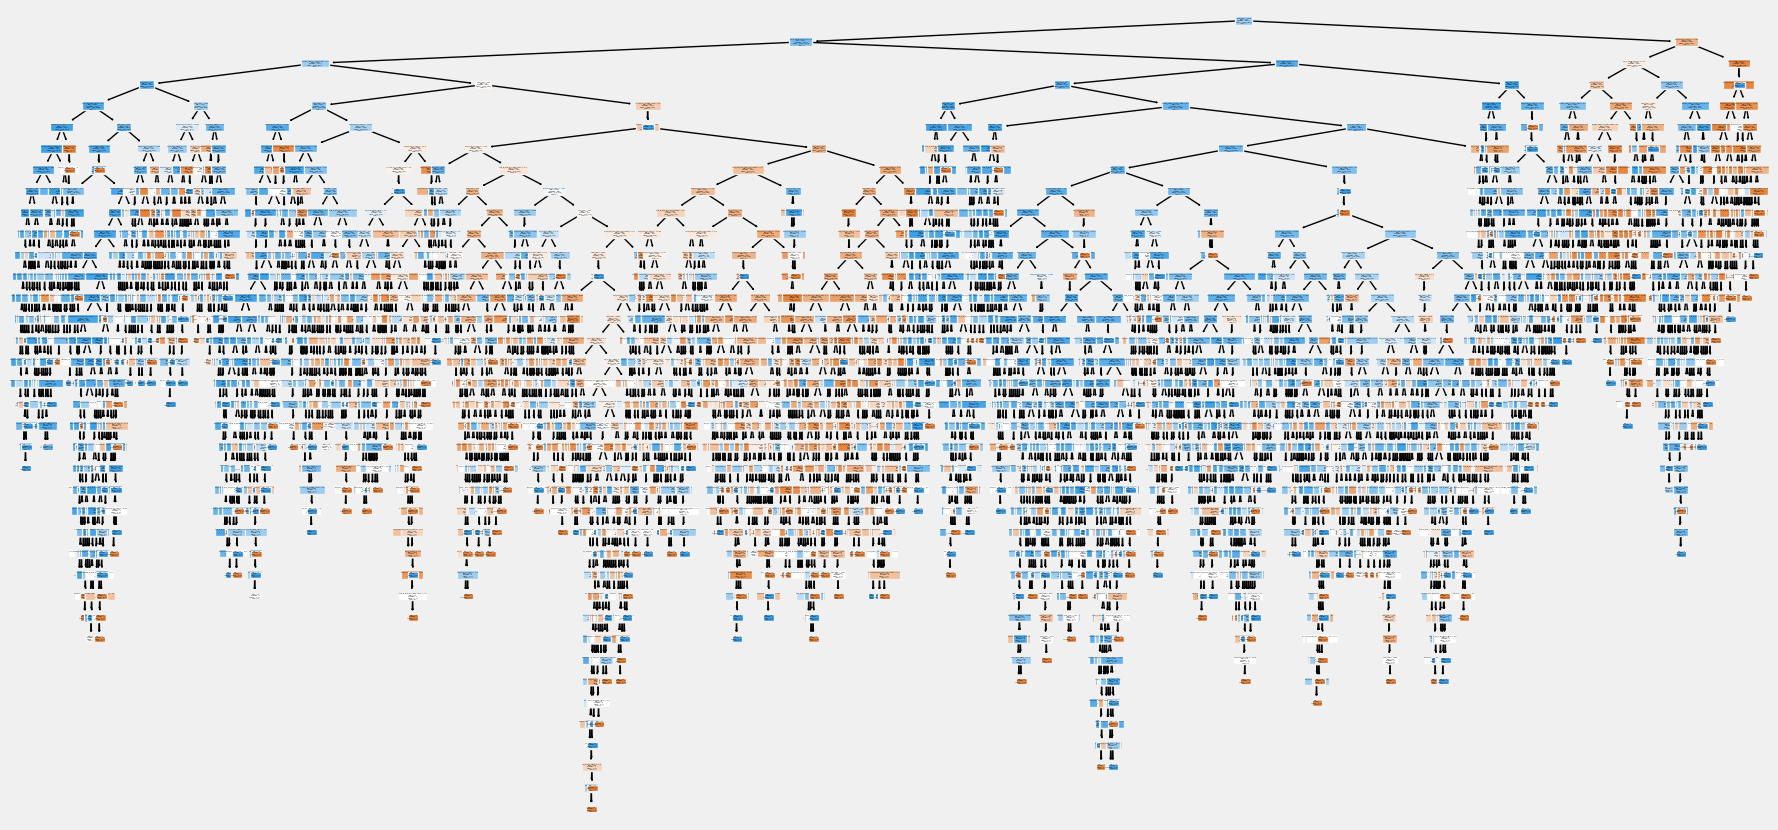

In [108]:
# import plot_tree from sklearn
from sklearn.tree import plot_tree
                           
plt.figure(figsize=(20,10))
plot_tree(
    clf, 
    feature_names=X.columns, 
    class_names='booking_status', 
    filled=True
)

# Show the plot
plt.show()


# TODO

1. Write model evaluations
1. Viz for decision tree
1. feature selection? https://www.datacamp.com/tutorial/feature-selection-python
1. Move time series stuff under regression and try with forecast?


## The Challenge

* Use your skills to produce recommendations for the hotel on what factors affect whether customers cancel their booking.

## Judging Criteria

| CATEGORY | WEIGHTING | DETAILS                                                            |
|---------|----------|---------------------------------------------------------------------|
| **Recommendations** | 35%       | <ul><li>Clarity of recommendations - how clear and well presented the recommendation is.</li><li>Quality of recommendations - are appropriate analytical techniques used & are the conclusions valid?</li><li>Number of relevant insights found for the target audience.</li></ul>       |
| **Storytelling**  | 35%       | <ul><li>How well the data and insights are connected to the recommendation.</li><li>How the narrative and whole report connects together.</li><li>Balancing making the report in-depth enough but also concise.</li></ul>|
| **Visualizations** | 20% | <ul><li>Appropriateness of visualization used.</li><li>Clarity of insight from visualization.</li></ul>|
| **Votes** | 10% | <ul><li>Up voting - most upvoted entries get the most points.</li></ul> |

## Checklist before publishing


* Rename your workspace to make it descriptive of your work. N.B. you should leave the notebook name as notebook.ipynb.
* Remove redundant cells like the judging criteria, so the workbook is focused on your work.
* Check that all the cells run without error.

## Time is ticking. Good luck! 